In [1]:
# import torch
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
version = 11003

results_path = f'sr_results/{version}.pkl'
reg = pickle.load(open(results_path, 'rb'))
# assert len(reg.equations_) == 2
# results = reg.equations_[0]  # equations for predicting the mean

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


[ Info: Precompiling SymbolicRegression [8254be44-1295-4e6a-a16d-46603ac705cb]
[ Info: Precompiling SymbolicRegressionJSON3Ext [b43b5d5b-9689-5a06-b5db-684afeae0d4f]


In [3]:
results = reg.equations_[0]

In [4]:
def number_of_variables_in_expression(equation: str):
    # assumes each variable is m{i} or s{i}
    # so we can just count the number of s's and count the number of m's
    # checking for a number after so "sin" doesn't get counted
    # assume max feature dim from f1 is 100
    count = 0
    for i in range(100):
        if 'm' + str(i) in equation:
            count += 1
        if 's' + str(i) in equation:
            count += 1

    return count

In [5]:
def overall_complexity(entry: pd.Series, k: int):
    complexity = entry['complexity']
    # return complexity
    num_variables = number_of_variables_in_expression(entry.equation)
    return complexity + (3 * k - 2) * num_variables

In [6]:
def get_important_complexities(results, loss_gap = 0.25):
    complexities = list(results['complexity'])
    losses = list(results['loss'])
    assert sorted(losses) == losses[::-1]

    # important complexities are those that decrease the loss by more than loss_gap since the previous important complexity.
    important_complexities = [complexities[0]]
    current_loss = losses[0]

    for i in range(1, len(complexities)):
        if current_loss - losses[i] > loss_gap:
            important_complexities.append(complexities[i])
            current_loss = losses[i]

    # automatically include the highest complexity too
    if complexities[-1] != important_complexities[-1]:
        important_complexities.append(complexities[-1])

    return important_complexities

In [7]:
k_results = pickle.load(open('k_results2.pkl', 'rb'))


In [8]:
k_results

{2: {1: 1.6445731477089376,
  3: 1.6321077422919545,
  4: 1.6006575097681797,
  5: 1.6285339954682407,
  7: 1.5244838153684388,
  9: 1.5378891398156485,
  11: 1.4493469839608395,
  13: 1.442788719756277,
  14: 1.4146021029426112,
  15: 1.4372154451769235,
  16: 1.407606487887196,
  17: 1.4244493089669876,
  18: 1.4089017238334829,
  19: 1.4088706287637414,
  20: 1.4017068165590165,
  22: 1.3785276244352802,
  23: 1.3849679559657035,
  24: 1.3745628442284694,
  25: 1.378958033813192,
  26: 1.344350946584523,
  27: 1.4012807573521064,
  29: 1.4052929906697569,
  30: 1.405091932078851},
 3: {1: 1.660671881091858,
  3: 1.6223875467038784,
  4: 1.645824223102835,
  5: 1.6087717944301345,
  7: 1.566291709764664,
  8: 1.5516637025771356,
  9: 1.5954111455445072,
  11: 1.5025013889046088,
  12: 1.5068639430016586,
  13: 1.532051188228798,
  14: 1.5195241893614078,
  16: 1.484357010581781,
  17: 1.4980780686533908,
  18: 1.4782627549610652,
  20: 1.4913909543643362,
  22: 1.4469040639112754,
  

In [9]:
d = {2: {'version': 24880,
         'pysr_version': 11003},
        #  'complexities': [1, 3, 5, 7, 9, 11, 14, 20, 29, 30]},
     3: {'version': 74649,
         'pysr_version': 83278},
        #  'complexities': [1, 3, 5, 7, 9, 13, 19, 35, 52, 60]},
     4: {'version': 11566,
         'pysr_version': 51254},
        #  'complexities': [1, 3, 5, 7, 10, 12, 16, 23, 56, 60]},
     5: {'version': 72646,
         'pysr_version': 55894}}
        #  'complexities': [1, 3, 5, 7, 11, 19, 27, 40, 59]}}

In [10]:
# goal is to have a table with k, complexity, loss, overall_rmse, overall_complexity
# 1. for each k, load the original PySR table
# 2. get rid of columns except for complexity and loss
# 3. filter to just the important complexities
# 4. for each important complexity, get the overall complexity and rmse
# k_results is a dict mapping k to a dict mapping an important complexity to rmse

k_tables = {}
for k, v in d.items():
    # load the original PySR table
    pysr_version = v['pysr_version']
    results_path = f'sr_results/{pysr_version}.pkl'
    reg = pickle.load(open(results_path, 'rb'))
    results = reg.equations_[0]

    # filter to just the important complexities
    # important_complexities = v['complexities']
    # results = results[results['complexity'].isin(important_complexities)]

    # for each important complexity, get the overall complexity and rmse
    results['overall_complexity'] = results.apply(lambda x: overall_complexity(x, k), axis=1)
    results['rmse'] = results.apply(lambda x: k_results[k][x['complexity']], axis=1)

    k_tables[k] = results


# merge the tables into one with column k
k_table = pd.concat([v.assign(k=k) for k, v in k_tables.items()])

In [11]:
# arrange the columns in the table so that it goes k, overall_complexity, rmse, then the others
cols = k_table.columns.tolist()
cols = [c for c in cols if c not in ['k', 'rmse', 'overall_complexity']]
cols = ['k', 'overall_complexity', 'rmse'] + cols
k_table = k_table[cols]

In [12]:
# save the k_table
k_table.to_csv('k_table.csv', index=False)

In [13]:
def plot(table, k):
    # get subtable where k=k
    table = table[table['k'] == k]
    x = table['overall_complexity']
    y = table['rmse']
    plt.scatter(x, y, s=12)
    plt.xlabel('Overall complexity', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.title(f'k = {k}', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.savefig(f'overall_complexity_{k}.png')
    plt.show()

In [14]:
f2_linear_df = pd.DataFrame({'k': [2, 5, 10, 20], 'rmse': [1.6071368459558846, 1.553364252893296, 1.572393983138787, 1.567916864697054]})

In [15]:
# calculate overall complexity
def overall_complexity_f2_linear(k):
    '''
    - k features. each feature is mean/std of a k=2 input feature, which has complexity 3.
    - we do a linear combination of the k features, so that is 3k-1 complexity for that.
    - also there's a bias term, so that adds complexity two (one for the constant, one for the additional plus)
    - total complexity: 2 + (3k-1)*3 = 9k - 3 + 1 = 9k - 1
    '''
    return 9 * k - 1

f2_linear_df['overall_complexity'] = f2_linear_df['k'].apply(overall_complexity_f2_linear)


In [16]:
f1_id_results = pickle.load(open('f1_id_results.pkl', 'rb'))

In [17]:
f1_id_results = pd.DataFrame(f1_id_results.items(), columns=['complexity', 'rmse'])

In [18]:
# for f1 identity, overall complexity is just the pysr complexity!
f1_id_results['overall_complexity'] = f1_id_results['complexity']

In [19]:
pure_sr_results = pd.DataFrame([
    (6, 3.0600863),
    (7, 2.8464127),
    (17, 2.807022),
    (18, 2.7902508),
    (20, 2.748974),
    (23, 2.7496042)],
    columns=['complexity', 'rmse'])

In [ ]:
pure_sr_results

,complexity,rmse
0,6,3.060086
1,7,2.846413
2,17,2.807022
3,18,2.790251
4,20,2.748974
5,23,2.749604


In [21]:
def paretoize(x, y):
    xy_sorted = sorted(zip(x, y), key=lambda t: t[0])
    pareto = []
    current_min = float('inf')
    for xx, yy in xy_sorted:
        if yy < current_min:
            pareto.append((xx, yy))
            current_min = yy
    x_pareto, y_pareto = zip(*pareto)
    return list(x_pareto), list(y_pareto)

def paretoize2(x, y):
    xy_sorted = sorted(zip(x, y), key=lambda t: t[0])
    best_so_far = float('inf')
    transformed = []

    for xx, yy in xy_sorted:
        if yy < best_so_far:
            best_so_far = yy
        transformed.append((xx, best_so_far))

    x_new, y_new = zip(*transformed)
    return list(x_new), list(y_new)

In [22]:
def plot_all(table):
    plt.figure(figsize=(5, 3))
    for kk in table['k'].unique():
        sub = table[table['k'] == kk].sort_values('overall_complexity')
        x = sub['overall_complexity']
        y = sub['rmse']
        x, y = paretoize2(x, y)
        plt.plot(x, y, marker='^', label=f'$k = {kk}$')

    # add the f2 linear model
    x = f2_linear_df['overall_complexity']
    y = f2_linear_df['rmse']
    x, y = paretoize2(x, y)
    plt.plot(x, y, marker='o', label='Linear $\psi$')

    # add f1 id results
    # x = f1_id_results['overall_complexity']
    # y = f1_id_results['rmse']
    # plt.plot(x, y, marker='o', label='f1 identity')

    # add pure SR results
    # x = pure_sr_results['complexity']
    # y = pure_sr_results['rmse']
    # plt.plot(x, y, marker='o', label='Pure SR')

    plt.xlabel('Overall complexity', fontsize=14)
    plt.ylabel('RMSE (Resonant)', fontsize=14)
    # plt.title('Pareto Frontiers for Different k', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend()
    plt.savefig('top_k_pareto.png')
    plt.show()

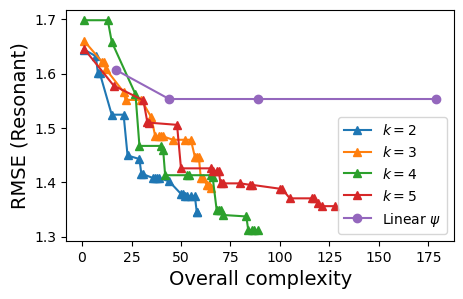

In [23]:
plot_all(k_table)